In [1]:
"""
Data preparation for wildfire events (2017-2023)

Fire data sources:
    - NIFC Interagency Final Wildfire Perimeters
    - FIRED events
    - MTBS perimeters

Extract the % forested for fire event polygons

Forest data source:
    - USFS TreeMap
  
Author: maxwell.cook@colorado.edu
"""

import os, sys, time, gc
import geopandas as gpd
import rioxarray as rxr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [2]:
# Load western US ecoregions
fp = os.path.join(projdir,'data/spatial/raw/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','NA_L3CODE','geometry']].rename(
    columns={'NA_L3NAME': 'na_l3name', 'NA_L3CODE': 'na_l3code'}
)
ecol3.columns

Index(['na_l3name', 'na_l3code', 'geometry'], dtype='object')

### National Interagency Fire Center (NIFC)

In [3]:
# Load the NIFC perimeters
fp = os.path.join(maindir,'data/nifc/mod/NIFC_AllPerimeters_to2023.gpkg')
nifc = gpd.read_file(fp)
# subset to fires 2017 onward
nifc['FIRE_YEAR'] = nifc['FIRE_YEAR'].astype(int) # force to integer
nifc = nifc[(nifc['FIRE_YEAR'] >= 2017) & (nifc['FIRE_YEAR'] != 9999)]
print(f"There are [{len(nifc)}] NIFC perimeters in CONUS.\n{nifc.columns}\n")
print(f"\tFire years: {nifc['FIRE_YEAR'].min()}-{nifc['FIRE_YEAR'].max()}")
# fix the geometries if needed
if (~nifc.geometry.is_valid).sum() > 0:
    nifc['geometry'] = nifc.geometry.buffer(0)
    print(f"\n\tFixed [{(~nifc.geometry.is_valid).sum()}] geometries.")

There are [22147] NIFC perimeters in CONUS.
Index(['OBJECTID', 'MAP_METHOD', 'DATE_CUR', 'COMMENTS', 'GEO_ID', 'IRWINID',
       'UNQE_FIRE_', 'FIRE_YEAR', 'LOCAL_NUM', 'INCIDENT', 'UNIT_ID',
       'POO_RESP_I', 'FEATURE_CA', 'GIS_ACRES', 'USER_NAME', 'SOURCE',
       'AGENCY', 'FIRE_YEAR_', 'Shape__Are', 'Shape__Len', 'FORID', 'OTHERID',
       'geometry'],
      dtype='object')

	Fire years: 2017-2023

	Fixed [0] geometries.


In [4]:
# Keep fires greater than at least 100 acres
nifc = nifc[nifc['GIS_ACRES'] >= 100]
print(f"[{len(nifc)}] fires >=100 acres.")

[7447] fires >=100 acres.


In [5]:
# Check for duplicates (different mapping methods, most likely)
n_duplicates = nifc.duplicated(subset='IRWINID').sum()
print(f"{n_duplicates} [{round(n_duplicates/len(nifc)*100, 2)}%] events have a duplicated IRWINID.")

2674 [35.91%] events have a duplicated IRWINID.


In [6]:
print(nifc['FEATURE_CA'].unique())
print("\n")
print(nifc['MAP_METHOD'].unique())

['Wildfire Final Fire Perimeter' 'Wildfire'
 'Wildfire Daily Fire Perimeter' 'Prescribed Fire'
 'Wildfire for Resource Benefit' 'RX']


['Infrared Interpretation' 'GPS - Uncorrected Data' 'Other'
 'Digitized-Other' 'Unknown' 'Digitized From Hardcopy Orthophoto quad'
 'GPS - Differentially Corrected Data' 'Photogrammetric Compilation'
 'Remote Sensing Data - Base Level' 'Digitized From Hardcopy PBS/SEQ'
 'Other Agency Digital' nan 'Remote Sensing Data - National Level'
 'GPS Survey Grade and Sub-meter' 'Digital Base Map'
 'Geographic Coordinate Database (GCDB)' 'Remote Sensing Data - Mid Level'
 'Remote Sensing Data - Broad Level' 'Hand Sketch' 'GPS-Flight'
 'GPS-Walked' 'GPS-Driven' 'Infrared Image' 'Digitized-Topo' 'GPS-Unknown'
 'GPS-Walked and Driven' 'Mixed Methods' 'Remote Sensing Derived'
 'Image Interpretation' 'Mixed Method' 'Not Recorded' 'Satellite' 'GPS'
 'GPS Flight' 'GPS-Unknown Travel Method' 'Digitized-Image'
 'Auto-generated' 'GPS Walked' 'IR Image Interpretation' 'Phon

In [7]:
# Resolve duplicate fire perimeters
# Attempt to keep only the 'Final Wildfire Perimeter'
def handle_duplicate_fires(group):
    """ 
    If there are duplicate IRWIN IDs, 
        1) Keep the 'Feature Category' == 'Final Wildfire Perimeter'. 
        2) If no such record exists, keep one of the records (first occurrence). 
    """
    if 'Wildfire Final Fire Perimeter' in group['FEATURE_CA'].values:
        return group[group['FEATURE_CA'] == 'Wildfire Final Fire Perimeter'].iloc[0]  # Keep 'Final' perimeter
    else:
        return group.iloc[0]  # If no 'Final' perimeter, keep the first record

# isolate the duplicate records
duplicates = nifc[nifc['IRWINID'].duplicated(keep=False)]  # Keep all duplicates
# apply our function to the duplicate records
resolved = duplicates.groupby('IRWINID').apply(handle_duplicate_fires).reset_index(drop=True)
# combine the resolved duplicates with the non-duplicates
non_duplicates = nifc[~nifc['IRWINID'].duplicated(keep=False)]  # keep only non-duplicates
nifc = pd.concat([non_duplicates, resolved], ignore_index=True) # merge back (clean data)

# check on the results
print(f"Number of unique duplicates: {len(duplicates['IRWINID'].unique())}/{len(duplicates)}")
print(f"Number of remaining fires after removing duplicates: {len(resolved)}")
print(f"\nThere are {len(nifc)} unique fire perimeters after resolving duplicates.")

del duplicates, resolved, non_duplicates
gc.collect() # clean up

Number of unique duplicates: 224/2898
Number of remaining fires after removing duplicates: 223

There are 4772 unique fire perimeters after resolving duplicates.


0

In [8]:
# Join to western U.S. ecoregions by fire centroid
# Identify the US EPA Level III ecoregion based on centroid of fire perimeter
centroids = nifc.copy() # make a copy of the fire data
centroids.geometry = centroids.geometry.centroid # use the centroid for joining to ecoregions
if not centroids.crs == ecol3.crs:
    print("CRS mismatch, fixing it !")
    centroids = centroids.to_crs(proj)
    ecol3 = ecol3.to_crs(proj)

# Perform the overlay analysis
nifc_west = gpd.overlay(centroids, ecol3, how='intersection') # find overlaps

print(f"\nThere are {len(nifc_west)} fire events across western U.S. ecoregions in CONUS (2017-2023).\n")


There are 3451 fire events across western U.S. ecoregions in CONUS (2017-2023).



In [9]:
# Replace the centroid geometry with the fire perimeter
# This ensure our fire data are in polygon format
nifc_west = gpd.GeoDataFrame(
    pd.merge(nifc_west[['OBJECTID','na_l3name']], nifc, left_on='OBJECTID', right_on='OBJECTID', how="left")
).rename(columns={'OBJECTID': 'NIFC_Fire_ID'})
print(f"Geometry set to fire perimeters: {nifc_west.geom_type.unique()}")
print(f"Data columns:\n{nifc_west.columns}")

Geometry set to fire perimeters: ['MultiPolygon' 'Polygon']
Data columns:
Index(['NIFC_Fire_ID', 'na_l3name', 'MAP_METHOD', 'DATE_CUR', 'COMMENTS',
       'GEO_ID', 'IRWINID', 'UNQE_FIRE_', 'FIRE_YEAR', 'LOCAL_NUM', 'INCIDENT',
       'UNIT_ID', 'POO_RESP_I', 'FEATURE_CA', 'GIS_ACRES', 'USER_NAME',
       'SOURCE', 'AGENCY', 'FIRE_YEAR_', 'Shape__Are', 'Shape__Len', 'FORID',
       'OTHERID', 'geometry'],
      dtype='object')


In [10]:
# save this file out.
out_fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-interagency_2017_to_2023_west.gpkg')
nifc_west.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/NIFC/nifc-interagency_2017_to_2023_west.gpkg


### Fire Events Delineation (FIRED)

In [11]:
fp = os.path.join(maindir,'FIRED/data/spatial/raw/events/conus_ak/fired_conus_ak_2000_to_2024_events.gpkg')
fired = gpd.read_file(fp)
fired = fired[(fired['ig_year'] >= 2017) & (fired['ig_year'] <= 2023)]
print(f"There are [{len(fired)}] FIRED perimeters in CONUS (2017-2023).\n{fired.columns}\n")

There are [102273] FIRED perimeters in CONUS (2017-2023).
Index(['id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mn_grw_px', 'mu_grw_px', 'mx_grw_km2', 'mn_grw_km2',
       'mu_grw_km2', 'mx_grw_dte', 'x', 'y', 'ig_utm_x', 'ig_utm_y', 'lc_code',
       'lc_mode', 'lc_name', 'lc_desc', 'lc_type', 'eco_mode', 'eco_name',
       'eco_type', 'tot_perim', 'geometry'],
      dtype='object')



In [12]:
# filter to retain fires >= 100 acres (same as NIFC)
fired['tot_ar_acres'] = fired['tot_ar_km2'] * 247.105381
fired = fired[fired['tot_ar_acres'] >= 100]
print(f"There are [{len(fired)}] FIRED perimeters >=100 acres.")

There are [54625] FIRED perimeters >=100 acres.


In [13]:
# Join to western U.S. ecoregions by fire centroid
# Identify the US EPA Level III ecoregion based on centroid of fire perimeter
centroids = fired.copy() # make a copy of the fire data
centroids.geometry = centroids.geometry.centroid # use the centroid for joining to ecoregions
if not centroids.crs == ecol3.crs:
    print("CRS mismatch, fixing it !")
    centroids = centroids.to_crs(proj)
    ecol3 = ecol3.to_crs(proj)

# Perform the overlay analysis
fired_west = gpd.overlay(centroids, ecol3, how='intersection') # find overlaps
print(f"\nThere are {len(fired_west)} FIRED events across western U.S. ecoregions in CONUS (2017-2023).\n")

CRS mismatch, fixing it !

There are 13859 FIRED events across western U.S. ecoregions in CONUS (2017-2023).



In [14]:
# Replace the centroid geometry with the fire perimeter
# This ensure our fire data are in polygon format
fired_west = gpd.GeoDataFrame(
    pd.merge(fired_west[['id','na_l3name']], fired, left_on='id', right_on='id', how="left")
).rename(columns={'id': 'FIRED_Fire_ID'})
print(f"Geometry set to fire perimeters: {fired_west.geom_type.unique()}")
print(f"Data columns:\n{fired_west.columns}")
del fired
gc.collect()

Geometry set to fire perimeters: ['MultiPolygon']
Data columns:
Index(['FIRED_Fire_ID', 'na_l3name', 'ig_date', 'ig_day', 'ig_month',
       'ig_year', 'last_date', 'event_dur', 'tot_pix', 'tot_ar_km2',
       'fsr_px_dy', 'fsr_km2_dy', 'mx_grw_px', 'mn_grw_px', 'mu_grw_px',
       'mx_grw_km2', 'mn_grw_km2', 'mu_grw_km2', 'mx_grw_dte', 'x', 'y',
       'ig_utm_x', 'ig_utm_y', 'lc_code', 'lc_mode', 'lc_name', 'lc_desc',
       'lc_type', 'eco_mode', 'eco_name', 'eco_type', 'tot_perim', 'geometry',
       'tot_ar_acres'],
      dtype='object')


0

In [15]:
# save this file out.
out_fp = os.path.join(projdir,'data/spatial/mod/FIRED/fired_events_2017_to_2023_west.gpkg')
fired_west.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/FIRED/fired_events_2017_to_2023_west.gpkg


### Monitoring Trends in Burn Severity (MTBS)

In [16]:
fp = os.path.join(maindir,'data/mtbs/mtbs_perimeter_data/mtbs_perims_DD.shp')
mtbs = gpd.read_file(fp)
mtbs.columns

Index(['Event_ID', 'irwinID', 'Incid_Name', 'Incid_Type', 'Map_ID', 'Map_Prog',
       'Asmnt_Type', 'BurnBndAc', 'BurnBndLat', 'BurnBndLon', 'Ig_Date',
       'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst', 'dNBR_stdDv', 'NoData_T',
       'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'Comment', 'geometry'],
      dtype='object')

In [17]:
# subset to 2017-2023
mtbs['Ig_Date'] = pd.to_datetime(mtbs['Ig_Date'], errors='coerce')
mtbs['Ig_Year'] = mtbs['Ig_Date'].dt.year
mtbs = mtbs[mtbs['Ig_Year'] >= 2017]
print(f"There are [{len(mtbs)}] MTBS perimeters in CONUS (2017-2023).\n{mtbs.columns}\n")

There are [6249] MTBS perimeters in CONUS (2017-2023).
Index(['Event_ID', 'irwinID', 'Incid_Name', 'Incid_Type', 'Map_ID', 'Map_Prog',
       'Asmnt_Type', 'BurnBndAc', 'BurnBndLat', 'BurnBndLon', 'Ig_Date',
       'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst', 'dNBR_stdDv', 'NoData_T',
       'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'Comment', 'geometry',
       'Ig_Year'],
      dtype='object')



In [18]:
# Join to western U.S. ecoregions by fire centroid
# Identify the US EPA Level III ecoregion based on centroid of fire perimeter
centroids = mtbs.copy() # make a copy of the fire data
centroids.geometry = centroids.geometry.centroid # use the centroid for joining to ecoregions
if not centroids.crs == ecol3.crs:
    print("CRS mismatch, fixing it !")
    centroids = centroids.to_crs(proj)
    ecol3 = ecol3.to_crs(proj)

# Perform the overlay analysis
mtbs_west = gpd.overlay(centroids, ecol3, how='intersection') # find overlaps
print(f"\nThere are {len(mtbs_west)} MTBS events across western U.S. ecoregions (2017-2023).\n")

CRS mismatch, fixing it !

There are 2259 MTBS events across western U.S. ecoregions (2017-2023).



In [19]:
# Replace the centroid geometry with the fire perimeter
# This ensure our fire data are in polygon format
mtbs_west = gpd.GeoDataFrame(
    pd.merge(mtbs_west[['Event_ID','na_l3name']], mtbs, left_on='Event_ID', right_on='Event_ID', how="left")
).rename(columns={'Event_ID': 'MTBS_Fire_ID'})
print(f"Geometry set to fire perimeters: {mtbs_west.geom_type.unique()}")
print(f"Data columns:\n{mtbs_west.columns}")
# del mtbs
gc.collect()

Geometry set to fire perimeters: ['Polygon' 'MultiPolygon']
Data columns:
Index(['MTBS_Fire_ID', 'na_l3name', 'irwinID', 'Incid_Name', 'Incid_Type',
       'Map_ID', 'Map_Prog', 'Asmnt_Type', 'BurnBndAc', 'BurnBndLat',
       'BurnBndLon', 'Ig_Date', 'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst',
       'dNBR_stdDv', 'NoData_T', 'IncGreen_T', 'Low_T', 'Mod_T', 'High_T',
       'Comment', 'geometry', 'Ig_Year'],
      dtype='object')


0

In [20]:
print(mtbs_west['Asmnt_Type'].unique())
print(mtbs_west['Incid_Type'].unique())

['Extended' 'Initial' 'Extended (SS)' 'Initial (SS)']
['Wildfire' 'Prescribed Fire' 'Unknown']


In [21]:
# save this file out.
out_fp = os.path.join(projdir,'data/spatial/mod/MTBS/mtbs_perims_2017_to_2023_west.gpkg')
mtbs_west.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/MTBS/mtbs_perims_2017_to_2023_west.gpkg


In [37]:
# Create a census of fire events for the Southern Rockies
# Use the three data sources to find all possible fire events
nifc = nifc_west[nifc_west['na_l3name'] == 'Southern Rockies']
mtbs = mtbs_west[mtbs_west['na_l3name'] == 'Southern Rockies'].to_crs(nifc.crs)
fired = fired_west[fired_west['na_l3name'] == 'Southern Rockies'].to_crs(nifc.crs)

# function to calculate spatial overlap
def fire_overlap(row, source):
    """Calculate the maximum overlap percentage with comparison_gdf."""
    overlap = source[source.intersects(row.geometry)]

    if overlap.empty:
        return 0
    # Calculate intersection areas
    overlap_ar = overlap.geometry.intersection(row.geometry).area
    overlap_pct = (overlap_ar / row.geometry.area).max()
    
    return overlap_pct

print(f"\n[{len(nifc)}] NIFC events.")
# apply the function to the MTBS perimeters
mtbs['nifc_overlap'] = mtbs.apply(fire_overlap, axis=1, args=(nifc,))
mtbs_ = mtbs[mtbs['nifc_overlap'] < 0.30]
print(f"\n\t{len(mtbs)-len(mtbs_)} fires [{round(len(mtbs)-len(mtbs_)/len(mtbs))}%] MTBS agreement")

# apply to FIRED events
fired['nifc_overlap'] = fired.apply(fire_overlap, axis=1, args=(nifc,))
fired_ = fired[fired['nifc_overlap'] < 0.30]
print(f"\n\t{len(fired_)}/{len(fired)} unique FIRED events.")

# FIRED, not overlapping MTBS
fired_['mtbs_overlap'] = fired_.apply(fire_overlap, axis=1, args=(mtbs_,))
fired_unq = fired_[fired_['mtbs_overlap'] < 0.30]
print(f"\n\t{len(fired_unq)} unique FIRED events (not overlapping MTBS).")


[116] NIFC events.

	55 fires [83%] MTBS agreement

	494/797 unique FIRED events (not overlapping NIFC).

	478 unique FIRED events (not overlapping MTBS).


In [60]:
# merge to create the fire "census"
# adopt a standard naming convention for dates and IDs, where possible
census = gpd.GeoDataFrame(
    pd.concat([nifc, mtbs_, fired_unq], ignore_index=True)
)

print(f"Fire census: {len(census)} events.\n")
census.columns

# save this out as a lookup table.
out_fp = os.path.join(projdir,'data/tabular/mod/srm_fire_census_2017_to_2023_lookup.csv')
census.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Fire census: 622 events.

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/srm_fire_census_2017_to_2023_lookup.csv


In [111]:
# handle the fire ID and names
census.rename(columns={
    'Event_ID': 'MTBS_Fire_ID',
}, inplace=True)

# create a column for the data source
census['Source'] = census[['NIFC_Fire_ID', 'MTBS_Fire_ID', 'FIRED_Fire_ID']].apply(
    lambda row: 'NIFC' if pd.notnull(row['NIFC_Fire_ID']) else
                'MTBS' if pd.notnull(row['MTBS_Fire_ID']) else
                'FIRED' if pd.notnull(row['FIRED_Fire_ID']) else None,
    axis=1
)

# create a new Fire ID
census['Fire_ID'] = census.index.astype(int)
# Combine the Fire_ID columns into a single column
census['Final_Acres'] = census[['GIS_ACRES', 'BurnBndAc', 'tot_ar_acres']].bfill(axis=1).iloc[:, 0]
census['Start_Date'] = census[['Ig_Date', 'ig_date']].bfill(axis=1).iloc[:, 0]
census['Start_Date'] = pd.to_datetime(census['Start_Date'], errors='coerce')
census['Start_Date'] = census['Start_Date'].dt.strftime('%Y-%m-%d')
census['Fire_Year'] = census[['FIRE_YEAR', 'Ig_Year', 'ig_year']].bfill(axis=1).iloc[:, 0]
census['Fire_Year'] = census['Fire_Year'].astype(int)
census['Fire_Name'] = census[['INCIDENT', 'Incid_Name']].bfill(axis=1).iloc[:, 0]
census['Fire_Type'] = census[['FEATURE_CA', 'Incid_Type']].bfill(axis=1).iloc[:, 0]
census['Fire_Type'] = census['Fire_Type'].fillna('Unknown')

# standardize the fire names
census['Fire_Name'] = census['Fire_Name'].str.upper()
# Drop the original Fire_ID columns (optional)
census_srm = census[['Fire_ID','Source','Fire_Name','Fire_Year','Start_Date','Final_Acres','Fire_Type','na_l3name','geometry']]
census_srm.head()

,Fire_ID,Source,Fire_Name,Fire_Year,Start_Date,Final_Acres,Fire_Type,na_l3name,geometry
0,0,NIFC,416,2018,NaN,54130.98,Wildfire Final Fire Perimeter,Southern Rockies,"MULTIPOLYGON (((-1041147.376 1662998.312, -104..."
1,1,NIFC,PLATEAU,2018,NaN,19677.32,Wildfire Final Fire Perimeter,Southern Rockies,"POLYGON ((-1086182.852 1697223.332, -1086195.7..."
2,2,NIFC,PLUMTAW,2022,NaN,721.40,Wildfire Final Fire Perimeter,Southern Rockies,"POLYGON ((-969458.337 1648162.315, -969460.344..."
3,3,NIFC,DOE CANYON,2019,NaN,2559.52,Wildfire Final Fire Perimeter,Southern Rockies,"POLYGON ((-1104109.134 1705466.516, -1104107.0..."
4,4,NIFC,CHRIS MOUNTAIN,2023,NaN,510.51,Wildfire Final Fire Perimeter,Southern Rockies,"MULTIPOLYGON (((-982490.650 1642500.578, -9824..."


In [112]:
census_srm['Fire_Type'].unique()

array(['Wildfire Final Fire Perimeter', 'Wildfire',
       'Wildfire Daily Fire Perimeter', 'Prescribed Fire', 'Unknown'],
      dtype=object)

In [113]:
# merge the calf canyon/hermit's peak polygons.
calf_hermit = census_srm[census_srm['Fire_Name'].isin(['CALF CANYON', 'HERMITS PEAK'])]
calf_hermit.sort_values(by=['Final_Acres'], ascending=False)
calf_hermit = calf_hermit.dissolve(by='Fire_Year', as_index=False)  # Use 'Fire_Year' or another common column
calf_hermit['Fire_Name'] = 'CALF CANYON-HERMITS PEAK'
calf_hermit['Final_Acres'] = calf_hermit.geometry.area * 0.000247105

# merge back in
census_srm = census_srm[~census_srm['Fire_Name'].isin(['CALF CANYON', 'HERMITS PEAK'])]
census_srm = pd.concat([census_srm, calf_hermit], ignore_index=True)

calf_hermit

,Fire_Year,geometry,Fire_ID,Source,Fire_Name,Start_Date,Final_Acres,Fire_Type,na_l3name
0,2022,"MULTIPOLYGON (((-855983.921 1432560.909, -8559...",16,NIFC,CALF CANYON-HERMITS PEAK,None,346871.216392,Wildfire Final Fire Perimeter,Southern Rockies


In [ ]:
# merge the calf canyon/hermit's peak polygons.
calf_hermit = census_srm[census_srm['Fire_Name'].isin(['CALF CANYON', 'HERMITS PEAK'])]
calf_hermit.sort_values(by=['Final_Acres'], ascending=False)
calf_hermit = calf_hermit.dissolve(by='Fire_Year', as_index=False)  # Use 'Fire_Year' or another common column
calf_hermit['Fire_Name'] = 'CALF CANYON-HERMITS PEAK'
calf_hermit['Final_Acres'] = calf_hermit.geometry.area * 0.000247105

# merge back in
census_srm = census_srm[~census_srm['Fire_Name'].isin(['CALF CANYON', 'HERMITS PEAK'])]
census_srm = pd.concat([census_srm, calf_hermit], ignore_index=True)

calf_hermit

In [114]:
len(census_srm)

621

In [115]:
# save this file out.
out_fp = os.path.join(projdir,'data/spatial/mod/srm_fire_census_2017_to_2023.gpkg')
census_srm.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/srm_fire_census_2017_to_2023.gpkg


### Calculate the percent forested from the USFS TreeMap (ca. 2016)

In [116]:
# Load the TreeMap (ca. 2016)
fp = os.path.join(maindir,'data/landcover/USFS/RDS_TreeMap/TreeMap2016_FORTYPCD/TreeMap2016_FORTYPCD.tif')
treemap_da = rxr.open_rasterio(fp, masked=True, cache=False, chunks='auto').squeeze()
# Grab some raster metadata
shp, gt, wkt, nd = treemap_da.shape, treemap_da.spatial_ref.GeoTransform, treemap_da.rio.crs, treemap_da.rio.nodata
print(
    f"Shape: {shp}; \n"
    f"GeoTransform: {gt}; \n"
    f"WKT: {wkt}; \n"
    f"NoData Value: {nd}; \n"
    f"Data Type: {treemap_da[0].dtype}")
gc.collect() # clean up

Shape: (97383, 154221); 
GeoTransform: -2362845.0 30.0 0.0 3180555.0 0.0 -30.0; 
WKT: EPSG:5070; 
NoData Value: nan; 
Data Type: float32


7111

In [117]:
# Crop the raster by the fire bounds (with small buffer)
bounds = census_srm.total_bounds
treemap_da_crop = treemap_da.rio.clip_box(
    minx=bounds[0]+1000, # +1000 meters for a small buffer
    miny=bounds[1]+1000, 
    maxx=bounds[2]+1000, 
    maxy=bounds[3]+1000
)
del treemap_da, bounds
gc.collect()

47

In [118]:
# Add a small buffer to wildfire perimeters
# Accounting for edge effects
buffer = 90  # meters
census_srm_ = census_srm.copy() # make a copy of the original data
census_srm_['geometry'] = census_srm_['geometry'].buffer(buffer)
print(f"Buffered fire perimeters by {buffer} meters.")

Buffered fire perimeters by 90 meters.


In [119]:
census_srm_.columns

Index(['Fire_ID', 'Source', 'Fire_Name', 'Fire_Year', 'Start_Date',
       'Final_Acres', 'Fire_Type', 'na_l3name', 'geometry'],
      dtype='object')

In [120]:
# Calculate zonal stats for the wildfire perimeters.
t0 = time.time()

# see __functions.py
sampled = compute_band_stats(census_srm_, treemap_da_crop, 'Fire_ID', attr='FORTYPCD')

t1 = (time.time() - t0) / 60
print(f"Total elapsed time: {t1:.2f} minutes.")
print("\n~~~~~~~~~~\n")

Total elapsed time: 0.09 minutes.

~~~~~~~~~~



In [121]:
sampled.head(3)

,Fire_ID,FORTYPCD,count,total_pixels,pct_cover
0,0,182,1801.0,238469.0,0.755234
1,0,184,187.0,238469.0,0.078417
2,0,185,2547.0,238469.0,1.068063


In [122]:
del treemap_da_crop
gc.collect()  # clean up

564

In [ ]:
# Load the lookup table and gather LC info

In [130]:
# load the species lookup table
fp = os.path.join(projdir,'data/tabular/mod/treemap_fortypcd_species_mapping.csv')
species_df = pd.read_csv(fp)[['FORTYPCD','SpeciesName']]
species_df = species_df[species_df['FORTYPCD'].isin(sampled['FORTYPCD'].unique())]
print(species_df.columns)

# merge with fire summary to get forest species name
fortypcd = sampled.merge(species_df, on='FORTYPCD', how='left')

# merge with the spatial data
fortypcd = pd.merge(fortypcd, census_srm_, on='Fire_ID', how='left')
fortypcd = gpd.GeoDataFrame(fortypcd)
fortypcd.head()

Index(['FORTYPCD', 'SpeciesName'], dtype='object')


,Fire_ID,FORTYPCD,count,total_pixels,pct_cover,SpeciesName,Source,Fire_Name,Fire_Year,Start_Date,Final_Acres,Fire_Type,na_l3name,geometry
0,0,182,1801.0,238469.0,0.755234,Rocky Mountain juniper,NIFC,416,2018,NaN,54130.98,Wildfire Final Fire Perimeter,Southern Rockies,"MULTIPOLYGON (((-1047907.942 1672642.863, -104..."
1,0,184,187.0,238469.0,0.078417,Juniper woodland,NIFC,416,2018,NaN,54130.98,Wildfire Final Fire Perimeter,Southern Rockies,"MULTIPOLYGON (((-1047907.942 1672642.863, -104..."
2,0,185,2547.0,238469.0,1.068063,Pinyon / juniper woodland,NIFC,416,2018,NaN,54130.98,Wildfire Final Fire Perimeter,Southern Rockies,"MULTIPOLYGON (((-1047907.942 1672642.863, -104..."
3,0,201,16810.0,238469.0,7.049134,Douglas-fir,NIFC,416,2018,NaN,54130.98,Wildfire Final Fire Perimeter,Southern Rockies,"MULTIPOLYGON (((-1047907.942 1672642.863, -104..."
4,0,221,25240.0,238469.0,10.584185,Ponderosa pine,NIFC,416,2018,NaN,54130.98,Wildfire Final Fire Perimeter,Southern Rockies,"MULTIPOLYGON (((-1047907.942 1672642.863, -104..."


In [131]:
# Identify fires with >= 1% aspen forest cover
aspen_fires = fortypcd[fortypcd['SpeciesName'] == 'Aspen']
print(f"There are {len(aspen_fires)} fires with some aspen component.")
# filter fires where "pct_aspen" >= 1%
aspen_fires = aspen_fires[['Fire_ID','pct_cover']].rename(columns={'pct_cover': 'pct_aspen'}) # subset columns
print(f"\nThere are [{len(aspen_fires[aspen_fires['pct_aspen'] >= 1])}] fire events with > 1% aspen cover in the SRM (2017-2023).\n")

There are 553 fires with some aspen component.

There are [440] fire events with > 1% aspen cover in the SRM (2017-2023).



In [132]:
# Join aspen percent to the spatial data.
census_srm_p = pd.merge(census_srm_, aspen_fires, on='Fire_ID', how='left')
census_srm_p['pct_aspen'] = census_srm_p['pct_aspen'].fillna(0)
census_srm_p = census_srm_p.to_crs(proj)  # ensure the correct projection before exporting
census_srm_p.columns

Index(['Fire_ID', 'Source', 'Fire_Name', 'Fire_Year', 'Start_Date',
       'Final_Acres', 'Fire_Type', 'na_l3name', 'geometry', 'pct_aspen'],
      dtype='object')

In [133]:
len(census_srm_p)

621

In [134]:
# save this file out.
out_fp = os.path.join(projdir,'data/spatial/mod/srm_fire_census_2017_to_2023.gpkg')
census_srm_p.to_file(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/srm_fire_census_2017_to_2023.gpkg


In [ ]:
# Map of aspen fires

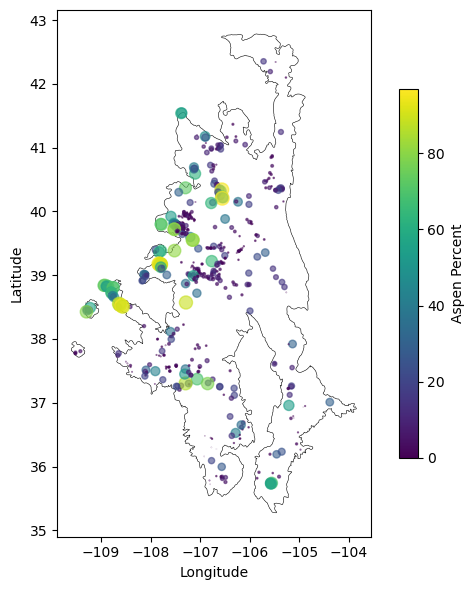

In [135]:
### Load the state boundaries
states = gpd.read_file(os.path.join(maindir,'data/boundaries/political/TIGER/tl19_us_states_west_nad83.gpkg'))
states = states.to_crs(4326)

ecol3 = ecol3.to_crs(4326)
srm = ecol3[ecol3['na_l3name'] == 'Southern Rockies']

# Generate centroids
centroid = census_srm_p.copy()
centroid = centroid.to_crs(4326)
centroid['geometry'] = centroid.geometry.centroid
centroid['size'] = centroid['pct_aspen'] * 10  # Adjust the scaling factor as necessary

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

srm.plot(ax=ax, edgecolor='black', linewidth=0.4, color='none')
centroid.plot(
    ax=ax, markersize=centroid['pct_aspen'], 
    column='pct_aspen', cmap='viridis', 
    legend=False, alpha=0.6)

# Manually add colorbar
norm = matplotlib.colors.Normalize(vmin=centroid['pct_aspen'].min(), vmax=centroid['pct_aspen'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Adjust the size of the colorbar using the `shrink` parameter
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Aspen Percent')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/Figure1_Aspen-Fires_NIFC_2012to2023.png'), dpi=300, bbox_inches='tight')

plt.show()

In [136]:
# Plot the count of fires across US EPA Level III ecoregions
df = fortypcd.groupby('na_l3name').agg(
    pct_cover_mean=('pct_cover', 'mean'),  # Mean percent cover
    fire_count=('pct_cover', 'count')      # Count of fires
).reset_index()
df

,na_l3name,pct_cover_mean,fire_count
0,Southern Rockies,8.466694,7311


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df = df.sort_values('fire_count', ascending=False)

norm = plt.Normalize(df['pct_cover_mean'].min(), df['pct_cover_mean'].max())
cmap = cm.viridis  # Choose a colormap

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(
    df['na_l3name'], 
    df['fire_count'], 
    color=cmap(norm(df['pct_cover_mean']))
)

# Add colorbar for mean percent cover
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Mean Percent Cover (%)', rotation=270, labelpad=15)

# Add labels and title
ax.set_xlabel('Ecoregion')
ax.set_ylabel('Fire Count')
ax.set_title('Fire Count and Mean Percent Cover by Ecoregion')
ax.set_xticks(range(len(df['na_l3name'])))
ax.set_xticklabels(df['na_l3name'], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
ecol3.columns

In [ ]:
# Southern Rockies

centroid_srm = centroid[centroid['na_l3name'] == 'Southern Rockies']
ecol3_srm = ecol3[ecol3['na_l3name'] == 'Southern Rockies']

# plot it
fig, ax = plt.subplots(figsize=(6, 6))

ecol3_srm.plot(ax=ax, edgecolor='black', linewidth=0.8, color='none')
centroid_srm.plot(
    ax=ax, markersize=centroid_srm['pct_cover'], 
    column='pct_cover', cmap='viridis', 
    legend=False, alpha=0.6)

# Manually add colorbar
norm = matplotlib.colors.Normalize(vmin=centroid_srm['pct_cover'].min(), vmax=centroid_srm['pct_cover'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Adjust the size of the colorbar using the `shrink` parameter
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Aspen Percent')

plt.xlabel('Longitude')
plt.ylabel('Latitude')


# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/Figure1_Aspen-Fires_NIFC-SRM.png'), dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
gc.collect()